In [1]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd

import re

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

torch.manual_seed(100)
np.random.seed(10)

In [2]:
def read_data_from_lya(train_fn, test_fn):
    train_data = pd.read_csv(train_fn, header=0)
    test_data = pd.read_csv(test_fn)
    
    dev_data = test_data.iloc[:2500, :]
    test_data = test_data.iloc[2500:, :]
    
    dev_data.reset_index(inplace=True, drop=True)
    test_data.reset_index(inplace=True, drop=True)
    
    return train_data, dev_data, test_data

def read_data(fn):
    vectors = []
    with open(fn, 'r') as f:
        for row in f.readlines():
            vectors.append([float(each) for each in row.strip().split()])
    cols = ['access', 'costs', 'delays', 'errors', 'trusts']
    vectors = pd.DataFrame(vectors, columns=cols)
    return vectors

def read_data_from_jaden(train_fn, dev_fn, test_fn):
    train_data = read_data(train_fn)
    dev_data = read_data(dev_fn)
    test_data = read_data(test_fn)
    
    return train_data, dev_data, test_data

def read_prediction():
    train_bert, dev_bert, test_bert = read_data_from_lya("../../data/predictions/lya_result_train.csv", "../../data/predictions/lya_result_test.csv")
    train_pooledrnn, dev_pooledrnn, test_pooledrnn = read_data_from_jaden("../../data/predictions/Pooled_RNN_Aspect_training_predict.txt", "../../data/predictions/Pooled_RNN_Aspect_dev_predict.txt", "../../data/predictions/Pooled_RNN_Aspect_test_predict.txt")
    train_attention, dev_attention, test_attention = read_data_from_jaden("../../data/predictions/Pooled_RNN_Aspect_training_predict.txt", "../../data/predictions/Pooled_RNN_Aspect_dev_predict.txt", "../../data/predictions/Pooled_RNN_Aspect_test_predict.txt")    
    
    train = pd.concat([train_bert, train_pooledrnn, train_attention], axis=1)
    dev = pd.concat([dev_bert, dev_pooledrnn, dev_attention], axis=1)
    test = pd.concat([test_bert, test_pooledrnn, test_attention], axis=1)    
    
    return train, dev, test
    
def read_true_label():
    train_label = pd.read_csv("../../data/predictions/train_true_label.csv", header=None, sep=" ")
    dev_label = pd.read_csv("../../data/predictions/dev_true_label.csv", header=None, sep=" ")
    test_label = pd.read_csv("../../data/predictions/test_true_label.csv", header=None, sep=" ")  
    
    train_label.columns = ["access", "costs", "delays", "errors", "trusts"]
    dev_label.columns = ["access", "costs", "delays", "errors", "trusts"]
    test_label.columns = ["access", "costs", "delays", "errors", "trusts"]    
    
    return train_label, dev_label, test_label

In [3]:
train_pre, dev_pre, test_pre = read_prediction()
train_true, dev_true, test_true = read_true_label()

In [4]:
test_pre.shape

(2500, 15)

In [5]:
dev_pre.shape, dev_true.shape

((2500, 15), (2500, 5))

In [6]:
test_pre.shape, test_true.shape

((2500, 15), (2500, 5))

# Model

In [7]:
class FcLayer(nn.Module):
    def __init__(self, in_dims, out_dims, dropout_rate):
        super(FcLayer, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_dims, out_dims),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(out_dims),            
            nn.LeakyReLU()
        )
    
    def forward(self, X):
        out = self.fc(X)
        return out  

class NNBaseline(nn.Module):
    def __init__(self, dims, dropout_rates):
        super(NNBaseline, self).__init__()
        
        N = len(dims)
        self.fcs = nn.ModuleList([FcLayer(dims[i], dims[i+1], dropout_rates[i]) for i in range(N - 2)])
        self.out_fc = nn.Linear(dims[-2], dims[-1])
    
    def forward(self, X):
        out = X
        for fc in self.fcs:
            out = fc(out)
        out = self.out_fc(out)
        return out         

In [24]:
def eval_metric(y_true, y_pred):
    metric = hamming_loss(y_true, y_pred)
    return metric

def fuzzy_acc(y_true, y_pred):
    fuzzy_acc = 0
    for true, pre in zip(y_true, y_pred):
        intersect = set(pre).intersection(set(true))
        if intersect != None and len(intersect) > 0:
            fuzzy_acc += 1
    fuzzy_acc = fuzzy_acc*1.0 / len(y_true)
    return fuzzy_acc

def convert_logits_to_label(logits):
    logits = logits > 0.6
    logits = logits.astype(int)
    return logits

def generate_loaders_from_numpy(X, y):    
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).float()
    dataset = TensorDataset(X_tensor, y_tensor)
    
    N = X.shape[0]
    
    train_size = int(N*0.8)
    val_size = N - train_size
    
#     train_dataset, val_dataset = random_split(dataset, [train_size, val_size])    
    
#     train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
#     val_loader = DataLoader(dataset=val_dataset, batch_size=val_size)    
#     return train_loader, val_loader

    train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    return train_loader

def make_single_train_step(net, loss_fn, optimizer):
    
    def train_step(X, y):
        
        net.train()
        
        y_pred = net(X)
        loss = loss_fn(y, y_pred)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        return loss.item()
    
    return train_step
        
    
def make_validation(net, loss, optimizer):
    
    def validate(X, y):
        
        net.eval()        
        
        with torch.no_grad():
            y_pred = net(X)
            loss = loss_fn(y, y_pred)    
            
            logits = torch.sigmoid(y_pred)
            y_pred_labels = convert_logits_to_label(logits.numpy())            
            metric = eval_metric(y.numpy(), y_pred_labels)
        return loss.item(), metric
    
    return validate

def make_evaluation(net, loss):
    
    def evaluate(X, y):        
        net.eval()        
        
        with torch.no_grad():
            y_pred = net(X)
            loss = loss_fn(y, y_pred)    
            
            logits = torch.sigmoid(y_pred)
            y_pred_labels = convert_logits_to_label(logits.numpy())       
            f1s = []
            for idx in range(y_pred_labels.shape[1]):
                print("********")
                print("label %s, confusion matrix:" % (classes[idx]))
                print(confusion_matrix(y[:, idx], y_pred_labels[:, idx]))
                f1 = f1_score(y[:, idx], y_pred_labels[:, idx])
                f1s.append(f1)
                print("f1: %f" % f1)
                print("********")
            avg_f1 = np.mean(f1s)
    
            y = y.numpy()
            hamming_score = 1 - hamming_loss(y, y_pred_labels)
            num_fuzzy_match = 0
            num_fuzzy_match_pos = 0
            num_exact_match_pos = 0
            num_pos = 0
            
            for pre, true in zip(y_pred_labels, y):
                if np.sum(true) != 0: 
                    num_pos += 1
                
                # calculate the intersection
                intersect = False
                for each_pre, each_true in zip(pre, true):
                    if each_pre == 1 and each_true == 1:
                        intersect = True
                if np.sum(pre) == 0 and np.sum(true) == 0:
                    intersect = True                
                
                if (np.sum(true)>0 and np.sum(pre)>0 and intersect) or (np.sum(true) == 0 and np.sum(pre) == 0):
                    num_fuzzy_match += 1
                if np.sum(true)>0 and np.sum(pre)>0 and intersect:
                    num_fuzzy_match_pos += 1
                if np.sum(true)>0 and np.sum(pre)>0 and np.array_equal(pre, true): 
                    num_exact_match_pos += 1
            fuzzy_accuracy = num_fuzzy_match*1.0 / y_pred_labels.shape[0]
            exact_accuracy = accuracy_score(y, y_pred_labels)
            fuzzy_accuracy_pos =  num_fuzzy_match_pos*1.0/num_pos
            exact_accuracy_pos = num_exact_match_pos*1.0/num_pos            
            roc = roc_auc_score(y, y_pred_labels, average="macro")
            
            
            print("avg f1 score: %f" % avg_f1)
            print("Hamming score: %f" % hamming_score)
            print("Exact accuracy: %f" % exact_accuracy)
            print("Fuzzy accuracy: %f" % fuzzy_accuracy)
            print("Exact accuracy (exclude negative): %f" % exact_accuracy_pos)
            print("Fuzzy accuracy (exclude negative): %f" % fuzzy_accuracy_pos)
            print("roc auc score (weighted): %f" % roc)
                                
        return loss.item()
    return evaluate        

def train(X, y, val_x, val_y, n_epochs=10, batch_size=32, lr=1e-4, net=None, loss_fn=None, optimizer=None, device=None):
    
    train_loader = generate_loaders_from_numpy(X, y)    
    val_x_tensor = torch.from_numpy(val_x).float()
    val_y_tensor = torch.from_numpy(val_y).float()    
    
    train_step = make_single_train_step(net, loss_fn, optimizer)
    validate_step = make_validation(net, loss_fn, optimizer)
    
    losses = []
    val_losses = []
    metrics = []
    best_loss = float("inf")
    for epoch in range(n_epochs):
        for idx, (X_batch, y_batch) in enumerate(train_loader):
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            loss = train_step(X_batch, y_batch)
            
            if idx % 100 == 0:
                            
                eval_loss, metric = validate_step(val_x_tensor, val_y_tensor)                            
                
                if eval_loss < best_loss:
                    best_loss = eval_loss
                    torch.save(net, "../../models/nn_ensemble.pt")
                
                losses.append(loss)                
                val_losses.append(eval_loss)
                metrics.append(metric)
                print("epoch: %d, iter: %d, training loss: %f, eval loss: %f, hamming loss: %f" % (epoch, idx, loss, eval_loss, metric))                            
                
    torch.save(net, "../../models/nn_ensemble_last.pt")
    
    return net, losses, val_losses, metrics
    
def test(data, label, net_fn, loss_fn=None):
    data = torch.from_numpy(data).float()
    label = torch.from_numpy(label).float()    
    
    model = torch.load(net_fn)
    evaluate_step = make_evaluation(model, loss_fn)        
    evaluate_step(data, label)    

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [10]:
n_epochs = 20
batch_size = 64
lr = 1e-4

# dims = [train_wv.shape[1], 1000, 500, 200, encoded_labels.shape[1]]
# dropout_rates = [0.1, 0.5, 0.5, 0.5]

dims = [train_pre.shape[1], 300, 200, 100, train_true.shape[1]]
dropout_rates = [0.1, 0.5, 0.5, 0.5]

classes = ["access", "costs", "delays", "errors", "trusts"]

In [11]:
def multilabel_loss(y_true, y_pred):
    output = nn.functional.binary_cross_entropy_with_logits(y_pred, y_true)
    return output

In [12]:
train_pre.shape, train_true.shape

((24603, 15), (24603, 5))

In [13]:
dev_pre.shape, dev_true.shape

((2500, 15), (2500, 5))

In [14]:
net = NNBaseline(dims, dropout_rates)
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_fn = multilabel_loss

model, losses, val_losses, metrics = train(train_pre.values, train_true.values, dev_pre.values, dev_true.values,
                                                     n_epochs=n_epochs, batch_size=batch_size, 
                                                     lr=lr, net=net, loss_fn=loss_fn, optimizer=optimizer, 
                                                     device=device)


/Users/zhengcao/anaconda3/envs/csci566/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type NNBaseline. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/zhengcao/anaconda3/envs/csci566/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/zhengcao/anaconda3/envs/csci566/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FcLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/zhengcao/anaconda3/envs/csci566/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't 

epoch: 0, iter: 0, training loss: 0.743875, eval loss: 0.691950, hamming loss: 0.043040
epoch: 0, iter: 100, training loss: 0.523685, eval loss: 0.641642, hamming loss: 0.036480
epoch: 0, iter: 200, training loss: 0.379938, eval loss: 0.575350, hamming loss: 0.038480
epoch: 0, iter: 300, training loss: 0.294956, eval loss: 0.524005, hamming loss: 0.037680
epoch: 1, iter: 0, training loss: 0.259872, eval loss: 0.482250, hamming loss: 0.037920
epoch: 1, iter: 100, training loss: 0.217313, eval loss: 0.437634, hamming loss: 0.036240
epoch: 1, iter: 200, training loss: 0.202880, eval loss: 0.396734, hamming loss: 0.035920
epoch: 1, iter: 300, training loss: 0.169731, eval loss: 0.364232, hamming loss: 0.036160
epoch: 2, iter: 0, training loss: 0.144684, eval loss: 0.345048, hamming loss: 0.036160
epoch: 2, iter: 100, training loss: 0.132283, eval loss: 0.321850, hamming loss: 0.035840
epoch: 2, iter: 200, training loss: 0.131946, eval loss: 0.301771, hamming loss: 0.036320
epoch: 2, iter: 

In [15]:
test_pre.shape

(2500, 15)

In [16]:
test_true.shape

(2500, 5)

In [25]:
# print("best model:")
# test(test_pre.values, test_true.values, net_fn="../../models/nn_ensemble.pt", loss_fn=loss_fn)

print("model for validation:")
test(dev_pre.values, dev_true.values, net_fn="../../models/nn_ensemble.pt", loss_fn=loss_fn)

print("\nmodel for test:")
test(test_pre.values, test_true.values, net_fn="../../models/nn_ensemble_last.pt", loss_fn=loss_fn)

model for validation:
********
label access, confusion matrix:
[[2148  163]
 [  27  162]]
f1: 0.630350
********
********
label costs, confusion matrix:
[[2274   97]
 [  16  113]]
f1: 0.666667
********
********
label delays, confusion matrix:
[[2346   68]
 [  22   64]]
f1: 0.587156
********
********
label errors, confusion matrix:
[[2405   42]
 [  20   33]]
f1: 0.515625
********
********
label trusts, confusion matrix:
[[2385   34]
 [  35   46]]
f1: 0.571429
********
avg f1 score: 0.594245
Hamming score: 0.958080
Exact accuracy: 0.798000
Fuzzy accuracy: 0.798000
Exact accuracy (exclude negative): 0.776952
Fuzzy accuracy (exclude negative): 0.776952
roc auc score (weighted): 0.849701

model for test:
********
label access, confusion matrix:
[[2121  212]
 [  14  153]]
f1: 0.575188
********
********
label costs, confusion matrix:
[[2308   71]
 [  22   99]]
f1: 0.680412
********
********
label delays, confusion matrix:
[[2344   61]
 [  33   62]]
f1: 0.568807
********
********
label errors, 

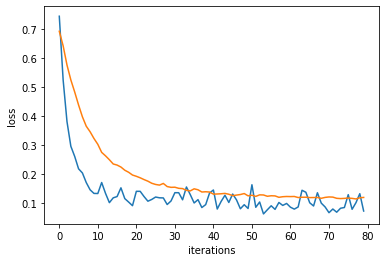

In [18]:
plt.plot(np.arange(len(losses)), losses)
plt.plot(np.arange(len(val_losses)), val_losses)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

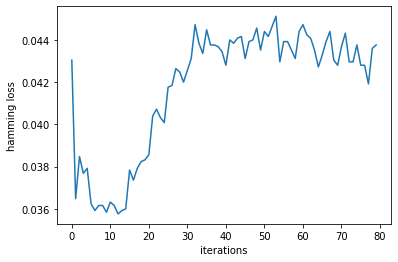

In [19]:
plt.plot(np.arange(len(metrics)), metrics)
plt.ylabel("hamming loss")
plt.xlabel("iterations")
plt.show()